<a href="https://www.kaggle.com/code/syahidarbi04/rent-predict?scriptVersionId=104016369" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/house-rent-prediction-dataset/Dataset Glossary.txt
/kaggle/input/house-rent-prediction-dataset/House_Rent_Dataset.csv


# Import function

In [2]:
#data visualization
import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats

#data preprocessing
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from imblearn import under_sampling, over_sampling
from sklearn.model_selection import train_test_split, RandomizedSearchCV

#machinelearning evaluation
from sklearn.metrics import mean_squared_error,r2_score

#machinelearning modeling
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

# Import Data

In [3]:
hr_df = pd.read_csv('/kaggle/input/house-rent-prediction-dataset/House_Rent_Dataset.csv')

In [4]:
#check data table
hr_df.head()

,Posted On,BHK,Rent,Size,Floor,Area Type,Area Locality,City,Furnishing Status,Tenant Preferred,Bathroom,Point of Contact
0,2022-05-18,2,10000,1100,Ground out of 2,Super Area,Bandel,Kolkata,Unfurnished,Bachelors/Family,2,Contact Owner
1,2022-05-13,2,20000,800,1 out of 3,Super Area,"Phool Bagan, Kankurgachi",Kolkata,Semi-Furnished,Bachelors/Family,1,Contact Owner
2,2022-05-16,2,17000,1000,1 out of 3,Super Area,Salt Lake City Sector 2,Kolkata,Semi-Furnished,Bachelors/Family,1,Contact Owner
3,2022-07-04,2,10000,800,1 out of 2,Super Area,Dumdum Park,Kolkata,Unfurnished,Bachelors/Family,1,Contact Owner
4,2022-05-09,2,7500,850,1 out of 2,Carpet Area,South Dum Dum,Kolkata,Unfurnished,Bachelors,1,Contact Owner


In [5]:
#cek null value

hr_df.isnull().sum()

Posted On            0
BHK                  0
Rent                 0
Size                 0
Floor                0
Area Type            0
Area Locality        0
City                 0
Furnishing Status    0
Tenant Preferred     0
Bathroom             0
Point of Contact     0
dtype: int64

In [6]:
#check data duplicate

hr_df.duplicated().any()

False

In [7]:
#check data info

hr_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4746 entries, 0 to 4745
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Posted On          4746 non-null   object
 1   BHK                4746 non-null   int64 
 2   Rent               4746 non-null   int64 
 3   Size               4746 non-null   int64 
 4   Floor              4746 non-null   object
 5   Area Type          4746 non-null   object
 6   Area Locality      4746 non-null   object
 7   City               4746 non-null   object
 8   Furnishing Status  4746 non-null   object
 9   Tenant Preferred   4746 non-null   object
 10  Bathroom           4746 non-null   int64 
 11  Point of Contact   4746 non-null   object
dtypes: int64(4), object(8)
memory usage: 445.1+ KB


In [8]:
# split data numeric and data object

num = hr_df.select_dtypes('number').columns.tolist()
cat = hr_df.select_dtypes('object').columns.tolist()

print('columns with dtype number is :', num)
print('columns with dtype object is :', cat)

columns with dtype number is : ['BHK', 'Rent', 'Size', 'Bathroom']
columns with dtype object is : ['Posted On', 'Floor', 'Area Type', 'Area Locality', 'City', 'Furnishing Status', 'Tenant Preferred', 'Point of Contact']


In [9]:
# basic numeric data statistic

hr_df[num].describe().T

,count,mean,std,min,25%,50%,75%,max
BHK,4746.0,2.083860,0.832256,1.0,2.0,2.0,3.0,6.0
Rent,4746.0,34993.451327,78106.412937,1200.0,10000.0,16000.0,33000.0,3500000.0
Size,4746.0,967.490729,634.202328,10.0,550.0,850.0,1200.0,8000.0
Bathroom,4746.0,1.965866,0.884532,1.0,1.0,2.0,2.0,10.0


In [10]:
# basic numeric data statistic

hr_df[cat].describe().T

,count,unique,top,freq
Posted On,4746,81,2022-07-06,311
Floor,4746,480,1 out of 2,379
Area Type,4746,3,Super Area,2446
Area Locality,4746,2235,Bandra West,37
City,4746,6,Mumbai,972
Furnishing Status,4746,3,Semi-Furnished,2251
Tenant Preferred,4746,3,Bachelors/Family,3444
Point of Contact,4746,3,Contact Owner,3216


1. data have 4746 rows and 12 columns
2. posted on can preprocessing into year and month
3. floor can split into floor and total floor
4. columns rent is target
5. no have value null
6. no have data duplicate
7. columns area locality can removed because to many unique value

# Data Cleansing

In [11]:
clean_df = hr_df.copy()

In [12]:
#Remove Area Locality because to many unique value there

clean_df = clean_df.drop(columns='Area Locality')

In [13]:
# check unique value in posted on column

clean_df['Posted On'].unique()

array(['2022-05-18', '2022-05-13', '2022-05-16', '2022-07-04',
       '2022-05-09', '2022-04-29', '2022-06-21', '2022-06-07',
       '2022-06-20', '2022-05-23', '2022-05-14', '2022-05-05',
       '2022-06-01', '2022-05-17', '2022-06-09', '2022-07-02',
       '2022-06-14', '2022-06-15', '2022-05-28', '2022-05-22',
       '2022-06-18', '2022-06-25', '2022-06-22', '2022-05-21',
       '2022-06-26', '2022-06-16', '2022-06-29', '2022-05-10',
       '2022-05-12', '2022-06-03', '2022-05-31', '2022-06-10',
       '2022-06-24', '2022-04-30', '2022-05-27', '2022-06-06',
       '2022-05-20', '2022-05-26', '2022-07-03', '2022-04-23',
       '2022-06-19', '2022-07-06', '2022-06-04', '2022-05-30',
       '2022-06-08', '2022-05-03', '2022-05-07', '2022-06-27',
       '2022-05-15', '2022-04-28', '2022-06-28', '2022-06-23',
       '2022-06-13', '2022-05-04', '2022-04-25', '2022-05-06',
       '2022-06-30', '2022-07-01', '2022-06-17', '2022-06-11',
       '2022-05-11', '2022-06-12', '2022-06-05', '2022-

In [14]:
#Split data Posted On to month_posted and save as integer (not split to year because year just have 1 unique value: 2022)

clean_df['month_posted'] = clean_df['Posted On'].str.split('-').str[1].astype(int)

clean_df = clean_df.drop(columns=['Posted On'])

In [15]:
#Floor columns have 2 value floor and total floor. we can split to floor and total floor. save as integer

clean_df['floor'] = clean_df['Floor'].str.split().str[0]
clean_df['total_floor'] = clean_df['Floor'].str.split().str[-1]

clean_df = clean_df.drop(columns=['Floor'])

In [16]:
#View value floor and total_floor

print('floor value: ', clean_df['floor'].unique())
print('-' *  100)
print('total_floor value: ', clean_df['total_floor'].unique())

floor value:  ['Ground' '1' '2' '4' '3' '5' '7' '8' 'Upper' '11' 'Lower' '6' '14' '43'
 '13' '18' '17' '9' '19' '60' '34' '12' '26' '25' '53' '16' '10' '39' '32'
 '47' '28' '20' '15' '65' '40' '37' '22' '21' '30' '35' '33' '44' '41'
 '46' '27' '45' '48' '50' '24' '23' '29' '49' '36' '76']
----------------------------------------------------------------------------------------------------
total_floor value:  ['2' '3' '1' '4' '5' '14' '8' '6' '19' '10' '7' '13' '78' '18' '12' '24'
 '31' '21' '23' '20' '9' '22' '58' '16' '66' '48' '40' '44' '42' '41' '60'
 '32' '30' '29' '89' '15' '11' '28' '17' '45' '35' '75' '38' '51' '43'
 '25' '27' '26' '76' '36' '37' '55' '68' '77' '50' '59' '62' '39' '52'
 '54' '33' '46' '85' '71' '81' '34' 'Ground']


In [17]:
# Replace data object to integer. Ground to 0, upper to 99 and lower to -1

clean_df['floor'].replace({'Ground':0, 'Upper':99, 'Lower':-1}, inplace = True)
clean_df['total_floor'].replace({'Ground':0},inplace = True)

In [18]:
#Change datatype object to integer

clean_df['floor'] = clean_df['floor'].astype(int)
clean_df['total_floor'] = clean_df['total_floor'].astype(int)

In [19]:
clean_df.head(5)

,BHK,Rent,Size,Area Type,City,Furnishing Status,Tenant Preferred,Bathroom,Point of Contact,month_posted,floor,total_floor
0,2,10000,1100,Super Area,Kolkata,Unfurnished,Bachelors/Family,2,Contact Owner,5,0,2
1,2,20000,800,Super Area,Kolkata,Semi-Furnished,Bachelors/Family,1,Contact Owner,5,1,3
2,2,17000,1000,Super Area,Kolkata,Semi-Furnished,Bachelors/Family,1,Contact Owner,5,1,3
3,2,10000,800,Super Area,Kolkata,Unfurnished,Bachelors/Family,1,Contact Owner,7,1,2
4,2,7500,850,Carpet Area,Kolkata,Unfurnished,Bachelors,1,Contact Owner,5,1,2


In [20]:
# split data numeric and data object

num = clean_df.select_dtypes('number').columns.tolist()
cat = clean_df.select_dtypes('object').columns.tolist()

print('columns with dtype number is :', num)
print('columns with dtype object is :', cat)

columns with dtype number is : ['BHK', 'Rent', 'Size', 'Bathroom', 'month_posted', 'floor', 'total_floor']
columns with dtype object is : ['Area Type', 'City', 'Furnishing Status', 'Tenant Preferred', 'Point of Contact']


In [21]:
# View details of the number of unique values ​​for each categorical column

for col in cat:
    print(f'Value unique columns {col}:')
    print(clean_df[col].nunique())
    print()
    print(f'Value count columns {col}:')
    print(clean_df[col].value_counts())
    print('-' * 50)

Value unique columns Area Type:
3

Value count columns Area Type:
Super Area     2446
Carpet Area    2298
Built Area        2
Name: Area Type, dtype: int64
--------------------------------------------------
Value unique columns City:
6

Value count columns City:
Mumbai       972
Chennai      891
Bangalore    886
Hyderabad    868
Delhi        605
Kolkata      524
Name: City, dtype: int64
--------------------------------------------------
Value unique columns Furnishing Status:
3

Value count columns Furnishing Status:
Semi-Furnished    2251
Unfurnished       1815
Furnished          680
Name: Furnishing Status, dtype: int64
--------------------------------------------------
Value unique columns Tenant Preferred:
3

Value count columns Tenant Preferred:
Bachelors/Family    3444
Bachelors            830
Family               472
Name: Tenant Preferred, dtype: int64
--------------------------------------------------
Value unique columns Point of Contact:
3

Value count columns Point of Conta

# Exploratory Data Analysis

In [22]:
eda_df = clean_df.copy()

In [23]:
# split data numeric and data object

num = eda_df.select_dtypes('number').columns.tolist()
cat = eda_df.select_dtypes('object').columns.tolist()

print('columns with dtype number is :', num)
print('columns with dtype object is :', cat)

columns with dtype number is : ['BHK', 'Rent', 'Size', 'Bathroom', 'month_posted', 'floor', 'total_floor']
columns with dtype object is : ['Area Type', 'City', 'Furnishing Status', 'Tenant Preferred', 'Point of Contact']


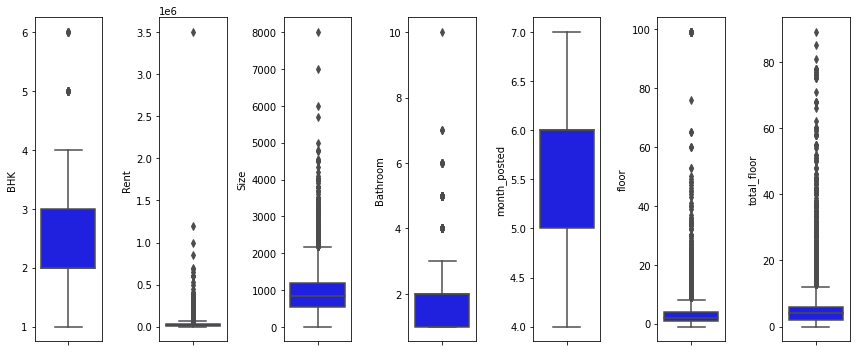

In [24]:
plt.figure(figsize=(12, 5))
for i in range(len(num)):
    plt.subplot(1,7,i+1)
    sns.boxplot(y = eda_df[num[i]], color='blue', orient='v')
    plt.tight_layout()

columns target have many outlier. we can remove some outlier values in the rent(target) column to reduce bias in the prediction results 

In [25]:
#Rent data outlier
eda_df[eda_df['Rent']>=800000]

,BHK,Rent,Size,Area Type,City,Furnishing Status,Tenant Preferred,Bathroom,Point of Contact,month_posted,floor,total_floor
827,4,1000000,3064,Carpet Area,Mumbai,Semi-Furnished,Family,4,Contact Agent,5,18,45
1001,4,1200000,5000,Carpet Area,Mumbai,Semi-Furnished,Bachelors/Family,4,Contact Agent,6,4,15
1329,4,850000,3200,Carpet Area,Mumbai,Furnished,Bachelors/Family,4,Contact Agent,6,2,4
1837,3,3500000,2500,Carpet Area,Bangalore,Semi-Furnished,Bachelors,3,Contact Agent,6,4,4


In [26]:
#drop row rent data outlier
eda_df = eda_df.drop(eda_df[eda_df['Rent']>=800000].index)

In [27]:
# Handling outlier

#out = ['Rent']

#print(f'num row before filtering outlier: {len(eda_df)}')

#filtered_entries = np.array([True] * len(eda_df))

#for col in out:
#    zscore = abs(stats.zscore(eda_df[col])) # sum absolute z-scorenya
#    filtered_entries = (zscore < 3) & filtered_entries # keep data with < 3 absolute z-score
    
#eda_df = eda_df[filtered_entries] # filter

#print(f'num row after filtering outlier: {len(eda_df)}')

In [28]:
eda_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4742 entries, 0 to 4745
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   BHK                4742 non-null   int64 
 1   Rent               4742 non-null   int64 
 2   Size               4742 non-null   int64 
 3   Area Type          4742 non-null   object
 4   City               4742 non-null   object
 5   Furnishing Status  4742 non-null   object
 6   Tenant Preferred   4742 non-null   object
 7   Bathroom           4742 non-null   int64 
 8   Point of Contact   4742 non-null   object
 9   month_posted       4742 non-null   int64 
 10  floor              4742 non-null   int64 
 11  total_floor        4742 non-null   int64 
dtypes: int64(7), object(5)
memory usage: 481.6+ KB


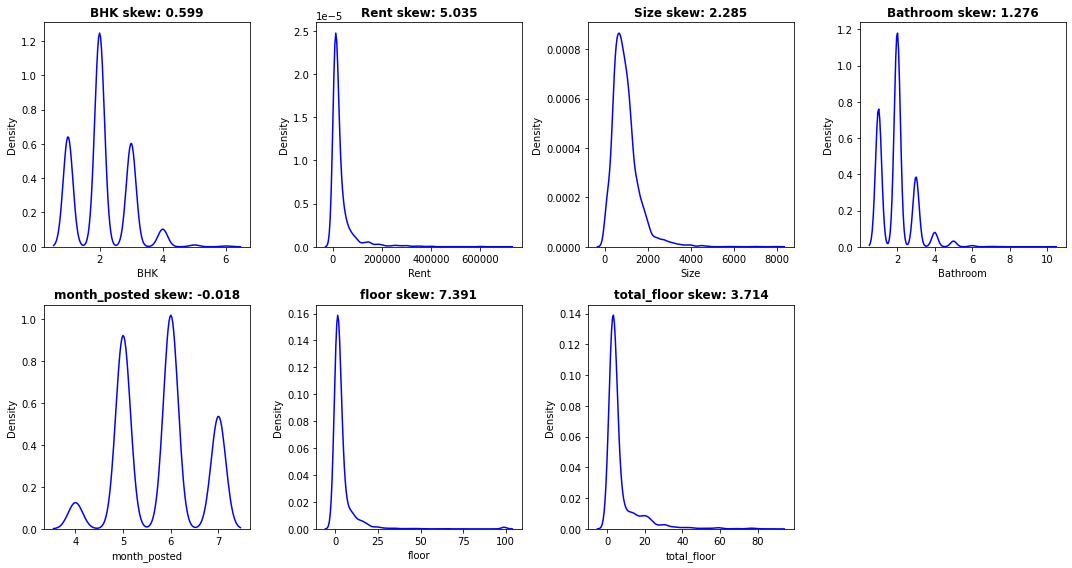

In [29]:
df_skew = eda_df[num].skew()

plt.figure(figsize=(15, 8))

for i in range(0, len(num)):
    plt.subplot(2, 4, i+1)
    sns.kdeplot(x=eda_df[num[i]], color='blue')
    plt.xlabel(num[i])
    plt.title(num[i] + ' skew: ' + str(round(df_skew[num[i]], 3)), fontsize = 12, fontweight = 'bold')
    plt.tight_layout()

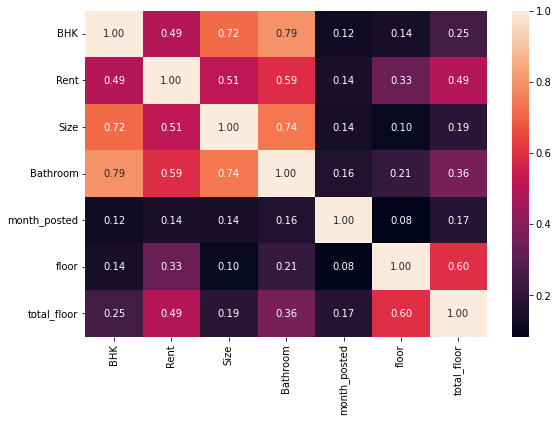

In [30]:
plt.figure(figsize = (9,6))
sns.heatmap(eda_df.corr(), annot = True, fmt = '.2f');

In [31]:
eda_df.corr()['Rent'].sort_values(ascending=False)

Rent            1.000000
Bathroom        0.593913
Size            0.513999
total_floor     0.494095
BHK             0.491727
floor           0.331530
month_posted    0.143885
Name: Rent, dtype: float64

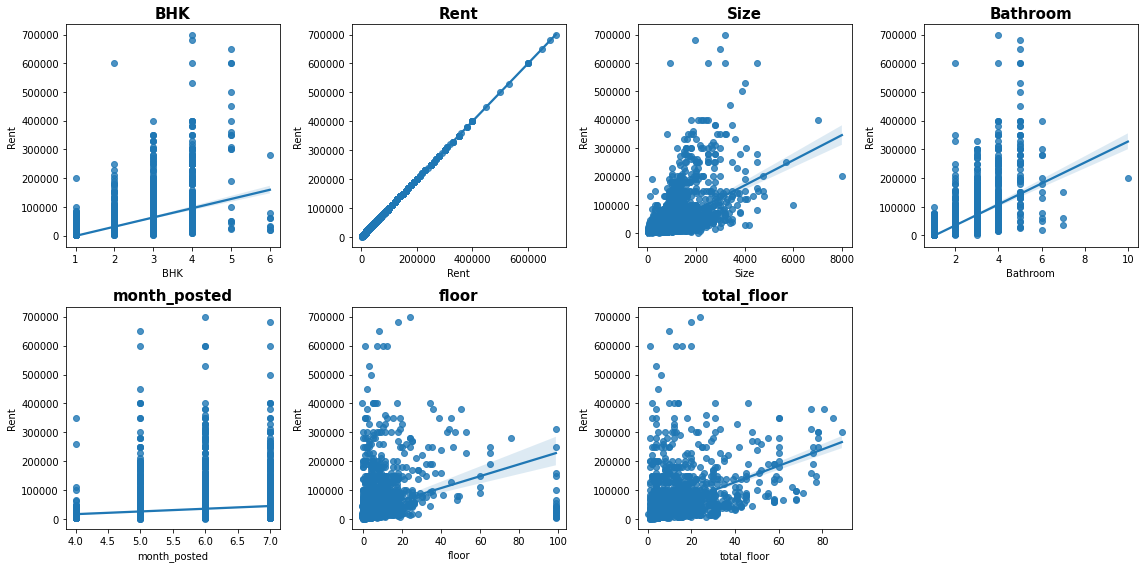

In [32]:
plt.figure(figsize=(16,8))

for i in range(0,len(num)):
    plt.subplot(2, 4, i+1)
    sns.regplot(x=eda_df[num[i]], y='Rent', data= eda_df, scatter=True)
    plt.title(str(num[i]), fontsize = 15, fontweight = 'bold')
    plt.tight_layout()

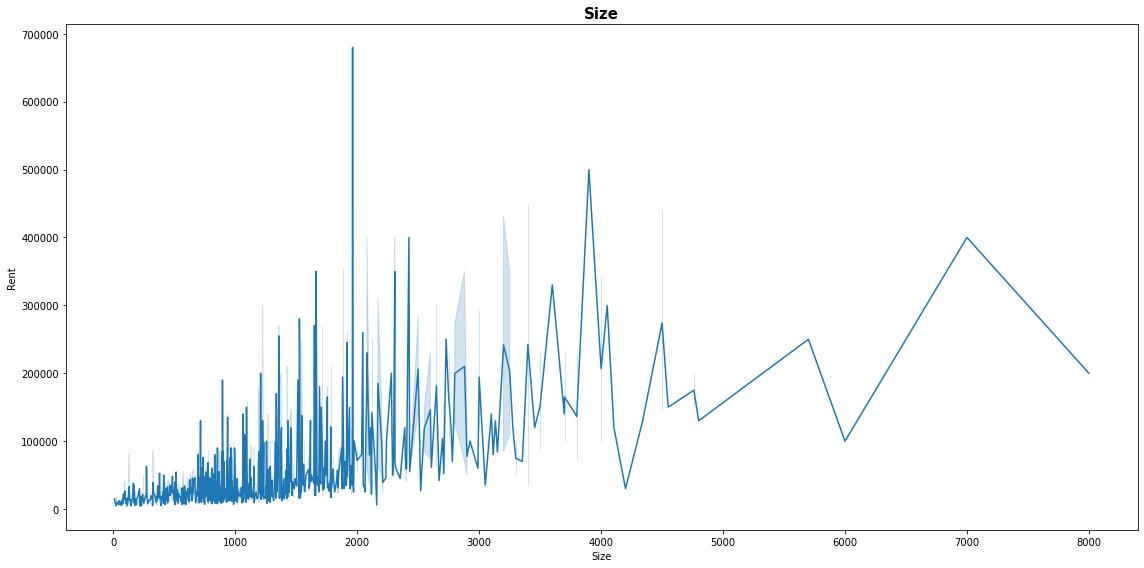

In [33]:
plt.figure(figsize=(16,8))
sns.lineplot(x='Size', y='Rent', 
            data=eda_df, 
            palette='Blues')
plt.xlabel('Size')
plt.ylabel('Rent')
plt.title('Size', fontsize = 15, fontweight = 'bold')
plt.tight_layout()

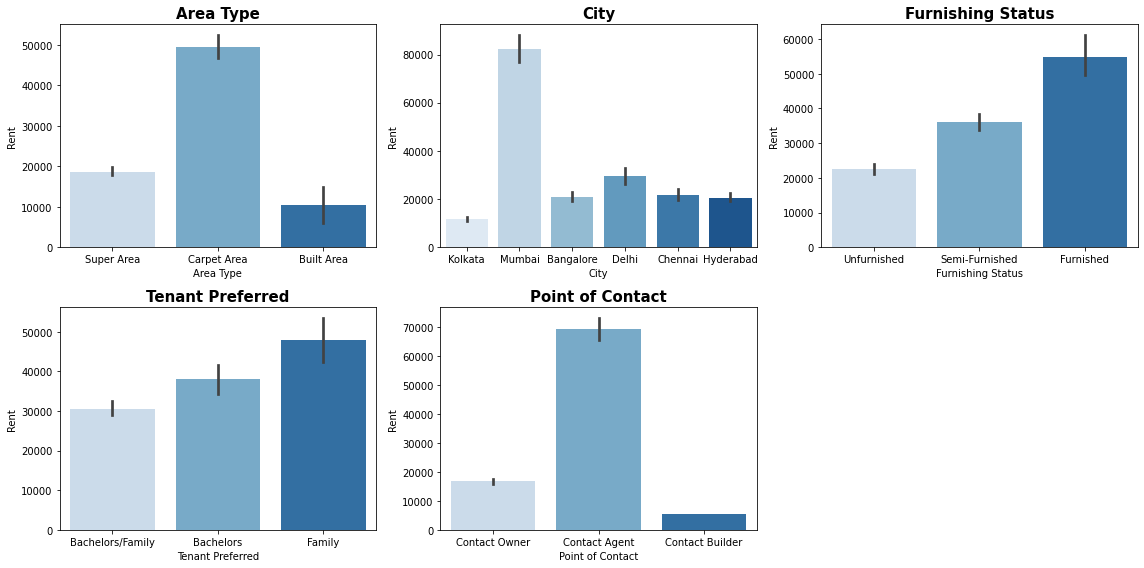

In [34]:
plt.figure(figsize=(16,8))
for i in range(0, len(cat)):
    plt.subplot(2,3,i+1)
    sns.barplot(x=cat[i], y='Rent', 
                data=eda_df, 
                palette='Blues')
    plt.xlabel(cat[i])
    plt.ylabel('Rent')
    plt.title(str(cat[i]), fontsize = 15, fontweight = 'bold')
    plt.tight_layout()

1. house/apartment with a carpet area type, the highest rental price compared to other types of areas
2. Mumbai is the city with the most expensive house/apartment rent prices compared to others
3. The house is divided into several furnishing statuses in order of the most expensive price, namely: furnishing, semi-furnishing, and unfurnishing.
4. The priority for the house is the family, the rent is more expensive.
5. rent price a house with a contact point at the agent has a more expensive value than others

In [35]:
def cat(col):
#determine size
    plt.figure(figsize=(11,5))
#define location sub plot
    plt.subplot(1, 2, 1)
#create barplot
    sns.barplot(x=col, y='Rent', 
                data=eda_df, 
                palette='Blues',
                estimator=np.mean)
#adding label
    plt.xlabel(col)
    plt.ylabel('Rent')
    plt.title('Average rent price of ' + str(col), fontsize = 15, fontweight = 'bold')
    plt.tight_layout()
    
    
#pieplot
#define data
    data = eda_df[col].value_counts()
    labels = eda_df[col].unique()
    
#define location sub plot
    plt.subplot(1, 2, 2)

#define Seaborn color palette to use
    colors = sns.color_palette('Spectral')

#create pie chart
    plt.pie(data, 
            labels=labels, 
            colors = colors,
            autopct='%.0f%%')
# draw circle
    centre_circle = plt.Circle((0,0), 0.70, fc='white')
    fig = plt.gcf()

# Adding Circle in Pie chart
    fig.gca().add_artist(centre_circle)

# Adding Title of chart
    plt.title(str(col) +' '+ 'value count datails', fontsize = 15, fontweight = 'bold')
    plt.show()


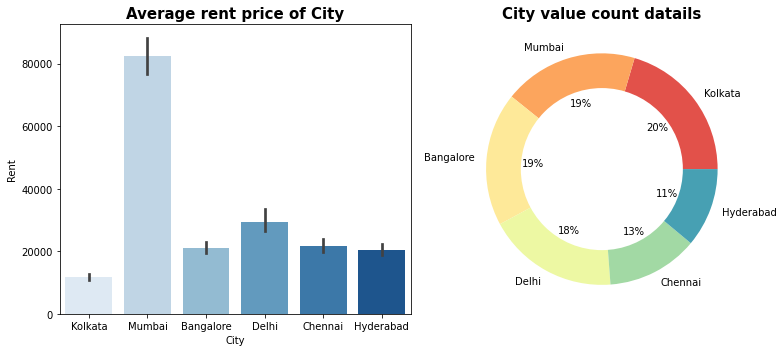

In [36]:
cat('City')

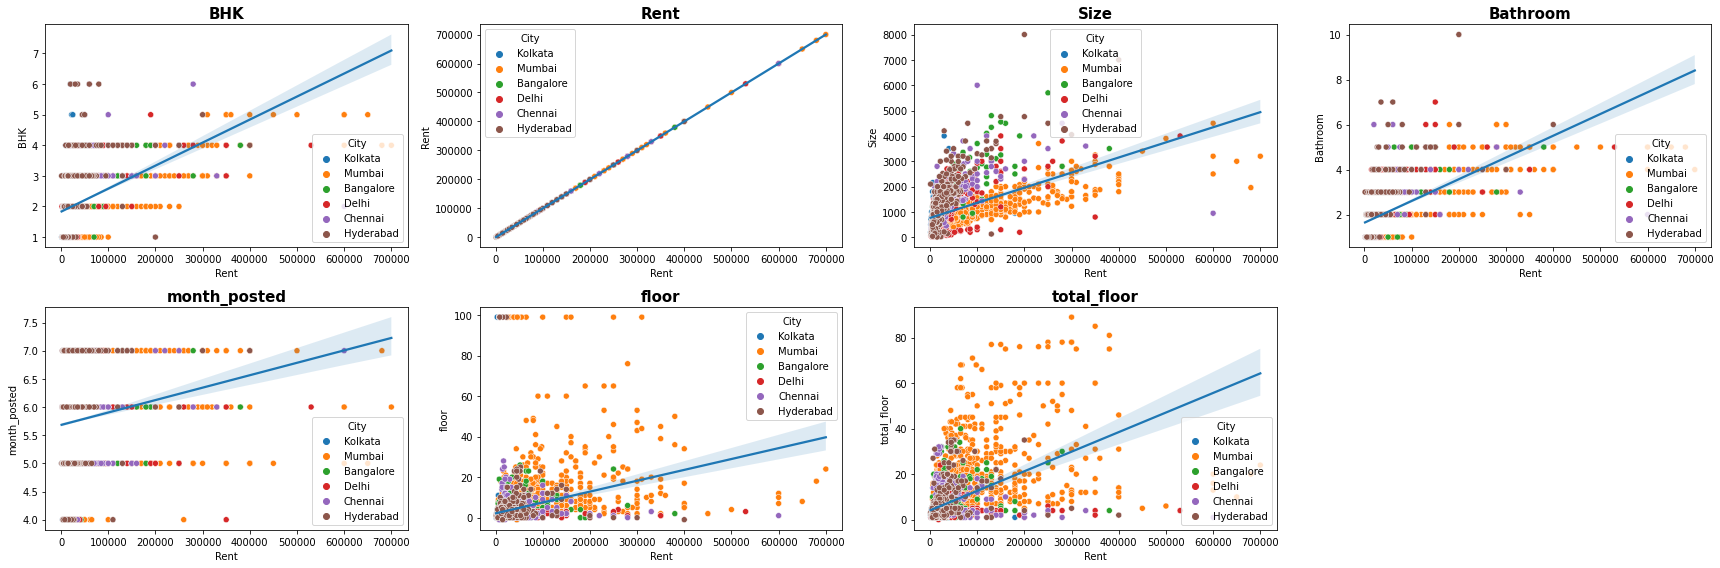

In [37]:
plt.figure(figsize=(24,8))

for i in range(0,len(num)):
    plt.subplot(2, 4, i+1)
    sns.scatterplot(y=eda_df[num[i]], x='Rent', hue='City', data=eda_df)
    sns.regplot(y=eda_df[num[i]], x='Rent', data= eda_df, scatter=False)
    plt.title(str(num[i]), fontsize = 15, fontweight = 'bold')
    plt.tight_layout()

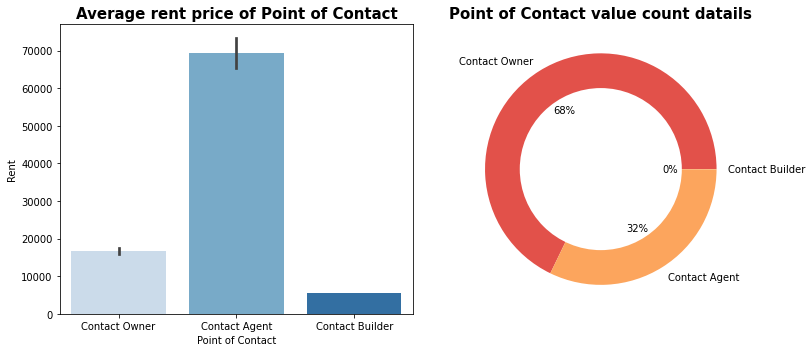

In [38]:
cat('Point of Contact')

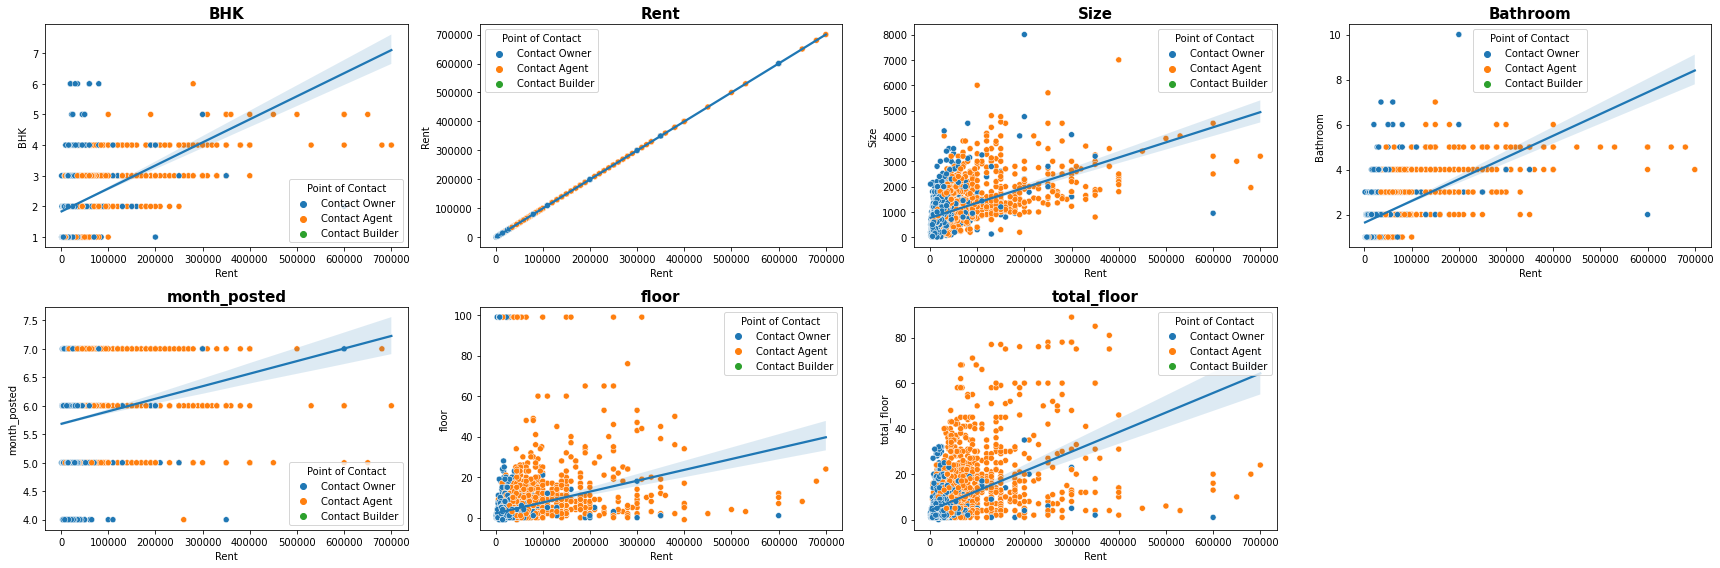

In [39]:
plt.figure(figsize=(24,8))

for i in range(0,len(num)):
    plt.subplot(2, 4, i+1)
    sns.scatterplot(y=eda_df[num[i]], x='Rent', hue='Point of Contact', data=eda_df)
    sns.regplot(y=eda_df[num[i]], x='Rent', data= eda_df, scatter=False)
    plt.title(str(num[i]), fontsize = 15, fontweight = 'bold')
    plt.tight_layout()

# Model Preparation

In [40]:
premodel = eda_df.copy()
premodel.head()

,BHK,Rent,Size,Area Type,City,Furnishing Status,Tenant Preferred,Bathroom,Point of Contact,month_posted,floor,total_floor
0,2,10000,1100,Super Area,Kolkata,Unfurnished,Bachelors/Family,2,Contact Owner,5,0,2
1,2,20000,800,Super Area,Kolkata,Semi-Furnished,Bachelors/Family,1,Contact Owner,5,1,3
2,2,17000,1000,Super Area,Kolkata,Semi-Furnished,Bachelors/Family,1,Contact Owner,5,1,3
3,2,10000,800,Super Area,Kolkata,Unfurnished,Bachelors/Family,1,Contact Owner,7,1,2
4,2,7500,850,Carpet Area,Kolkata,Unfurnished,Bachelors,1,Contact Owner,5,1,2


## Data Encoding

In [41]:
map_furnishing_status = {
    'Unfurnished' : 0,
    'Semi-Furnished' : 1,
    'Furnished' : 2}


premodel['Furnishing Status'] = premodel['Furnishing Status'].map(map_furnishing_status)


premodel.sample(3)

,BHK,Rent,Size,Area Type,City,Furnishing Status,Tenant Preferred,Bathroom,Point of Contact,month_posted,floor,total_floor
390,2,10000,700,Carpet Area,Kolkata,1,Bachelors,2,Contact Owner,7,1,1
3748,2,13500,950,Super Area,Chennai,1,Bachelors/Family,2,Contact Owner,5,0,3
4622,2,15000,1205,Super Area,Hyderabad,2,Bachelors/Family,2,Contact Owner,6,3,5


In [42]:
# One hot encoding
for cat in ['Area Type', 'City', 'Tenant Preferred', 'Point of Contact']:
    onehots = pd.get_dummies(premodel[cat], prefix=cat)
    premodel = premodel.join(onehots)

In [43]:
# Drop columns
premodel = premodel.drop(columns = ['Area Type', 'City', 'Tenant Preferred', 'Point of Contact'])
premodel.sample(3)

,BHK,Rent,Size,Furnishing Status,Bathroom,month_posted,floor,total_floor,Area Type_Built Area,Area Type_Carpet Area,...,City_Delhi,City_Hyderabad,City_Kolkata,City_Mumbai,Tenant Preferred_Bachelors,Tenant Preferred_Bachelors/Family,Tenant Preferred_Family,Point of Contact_Contact Agent,Point of Contact_Contact Builder,Point of Contact_Contact Owner
4307,2,13000,1225,0,2,5,2,4,0,0,...,0,1,0,0,1,0,0,0,0,1
3051,2,30000,1200,1,2,7,3,3,0,1,...,0,0,0,0,0,1,0,1,0,0
1377,1,24000,430,2,2,5,6,7,0,1,...,0,0,0,1,0,1,0,1,0,0


In [44]:
premodel.corr()['Rent'].sort_values(ascending=False)

Rent                                 1.000000
Bathroom                             0.593913
Size                                 0.513999
total_floor                          0.494095
BHK                                  0.491727
City_Mumbai                          0.455443
Point of Contact_Contact Agent       0.453169
floor                                0.331530
Area Type_Carpet Area                0.284909
Furnishing Status                    0.197196
month_posted                         0.143885
Tenant Preferred_Family              0.087838
Tenant Preferred_Bachelors           0.036715
Point of Contact_Contact Builder    -0.007527
Area Type_Built Area                -0.008755
City_Delhi                          -0.029438
Tenant Preferred_Bachelors/Family   -0.090156
City_Chennai                        -0.106552
City_Bangalore                      -0.111177
City_Hyderabad                      -0.114088
City_Kolkata                        -0.142790
Area Type_Super Area              

## Describe Feature and Target

In [45]:
x = premodel.drop(columns=['Rent'])
y = premodel['Rent']

print(x.shape)
print(y.shape)

(4742, 22)
(4742,)


In [46]:
# Split data train & test

xtrain, xtest, ytrain, ytest = train_test_split(x, y, test_size = 0.3, random_state = 42)

print('num data train: ', xtrain.shape)
print('num data test: ', xtest.shape)

num data train:  (3319, 22)
num data test:  (1423, 22)


In [47]:
ytrain = np.array(ytrain).reshape(ytrain.shape[0], 1)
ytest = np.array(ytest).reshape(ytest.shape[0], 1)

mms = MinMaxScaler()

x_train = mms.fit_transform(xtrain)
y_train = mms.fit_transform(ytrain)

x_test = mms.fit_transform(xtest)
y_test = mms.fit_transform(ytest)

# Modeling

In [48]:
# Modeling

model_rfr = RandomForestRegressor(n_estimators=700, max_depth=70, min_samples_leaf=3, min_samples_split= 5,random_state=42)
model_rfr.fit(x_train, y_train.reshape(len(y_train),))

RandomForestRegressor(max_depth=70, min_samples_leaf=3, min_samples_split=5,
                      n_estimators=700, random_state=42)

In [49]:
#Predict and model evaluation train

ypred_train = model_rfr.predict(x_train)

print('rmse: ', mean_squared_error(y_train, ypred_train,squared=False ))
print('r2: ', r2_score(y_train, ypred_train))

rmse:  0.0276290152785196
r2:  0.8877056100263824


<AxesSubplot:>

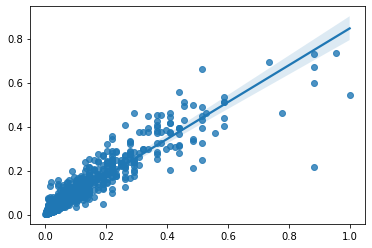

In [50]:
sns.regplot(x=y_train, y=ypred_train, data= eda_df, scatter=True)

In [51]:
ypred_train = mms.inverse_transform(ypred_train.reshape(len(ytrain),1))

print(np.concatenate((ypred_train.reshape(len(ypred_train),1), ytrain.reshape(len(ytrain),1)),1))

[[ 15979.02368575  14000.        ]
 [  8121.53583183   5700.        ]
 [ 10552.49654409   7000.        ]
 ...
 [ 30207.69521194  30000.        ]
 [  7445.71082661   6000.        ]
 [140707.10050981  90000.        ]]


In [52]:
# Predict and model evaluation data test

ypred=model_rfr.predict(x_test)

print('rmse: ', mean_squared_error(y_test,ypred,squared=False ))
print('r2: ', r2_score(y_test,ypred))

rmse:  0.03754079284724647
r2:  0.7270832126031778


Text(0.5, 0, 'Rent_actual')

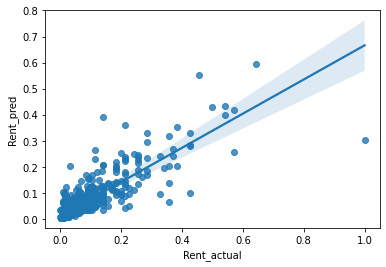

In [53]:
sns.regplot(x=y_test, y=ypred, data= eda_df, scatter=True)
plt.ylabel('Rent_pred')
plt.xlabel('Rent_actual')

In [54]:
ypred = mms.inverse_transform(ypred.reshape(len(ytest),1))

print(np.concatenate((ypred.reshape(len(ypred),1), ytest.reshape(len(ytest),1)),1))

[[19453.86909468 20000.        ]
 [33778.26168048 40000.        ]
 [18272.71176617 15000.        ]
 ...
 [10495.64700561  8500.        ]
 [58763.95783921 90000.        ]
 [ 9180.33847258  8000.        ]]


## Hyperparameter Tuning

In [55]:
def fine_tune(model, param_grid):
    random_search = RandomizedSearchCV(model, param_grid, cv=5, scoring='neg_mean_squared_error', return_train_score=True, random_state=42)
    random_search.fit(x_train, y_train.reshape(len(y_train),))
    return random_search.best_params_, np.sqrt((-1)*random_search.best_score_)

In [56]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 125, stop = 1000, num = 8)]

# Number of features to consider at every split
max_features = ['auto', 'sqrt']

# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(20, 100, num = 5)]
max_depth.append(None)

# Minimum number of samples required to split a node
min_samples_split = [int(x) for x in np.linspace(5, 20, num = 4)]

# Minimum number of samples required at each leaf node
min_samples_leaf = [int(x) for x in np.linspace(3, 15, num = 5)]

# Method of selecting samples for training each tree
bootstrap = [True, False]

# Create the random grid
param_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

print(param_grid)

{'n_estimators': [125, 250, 375, 500, 625, 750, 875, 1000], 'max_features': ['auto', 'sqrt'], 'max_depth': [20, 40, 60, 80, 100, None], 'min_samples_split': [5, 10, 15, 20], 'min_samples_leaf': [3, 6, 9, 12, 15], 'bootstrap': [True, False]}


In [57]:
fine_tune(model_rfr, param_grid)

({'n_estimators': 875,
  'min_samples_split': 10,
  'min_samples_leaf': 3,
  'max_features': 'auto',
  'max_depth': 100,
  'bootstrap': True},
 0.04354690563575102)

In [58]:
final_model = RandomForestRegressor(n_estimators=875,
                                    min_samples_split=10,
                                    min_samples_leaf=3,
                                    max_features ='auto',
                                    max_depth=100,
                                    bootstrap=True, random_state=42)

In [59]:
final_model.fit(x_train, y_train.reshape(len(y_train),))

RandomForestRegressor(max_depth=100, min_samples_leaf=3, min_samples_split=10,
                      n_estimators=875, random_state=42)

In [60]:
ypred=final_model.predict(x_train)

print('rmse: ', mean_squared_error(y_train,ypred,squared=False ))
print('r2: ', r2_score(y_train,ypred))

rmse:  0.030585282545780534
r2:  0.862389288352945


In [61]:
ypred=final_model.predict(x_test)

print('rmse: ', mean_squared_error(y_test,ypred,squared=False ))
print('r2: ', r2_score(y_test,ypred))

rmse:  0.03715562444636095
r2:  0.7326547338609408


Text(0.5, 0, 'Rent_actual')

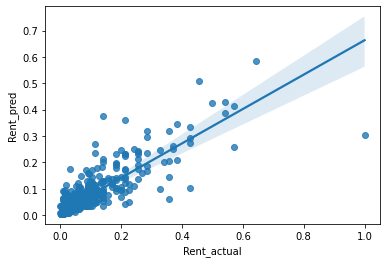

In [62]:
sns.regplot(x=y_test, y=ypred, data= eda_df, scatter=True)
plt.ylabel('Rent_pred')
plt.xlabel('Rent_actual')

In [63]:
ypred = mms.inverse_transform(ypred.reshape(len(ytest),1))

result_array = np.concatenate((ypred.reshape(len(ypred),1), ytest.reshape(len(ytest),1)),1)

df_result = pd.DataFrame(result_array, columns = ['Predict_Value','Actual_value'])

In [64]:
df_result.sample(10)

,Predict_Value,Actual_value
1061,22717.094338,21000.0
1080,17468.619564,12000.0
447,12790.438095,14000.0
693,9811.577615,7000.0
646,17398.312259,24000.0
221,27720.121080,45000.0
968,14285.326882,25000.0
727,11488.139592,11000.0
895,26058.472663,18000.0
810,11042.355615,14000.0


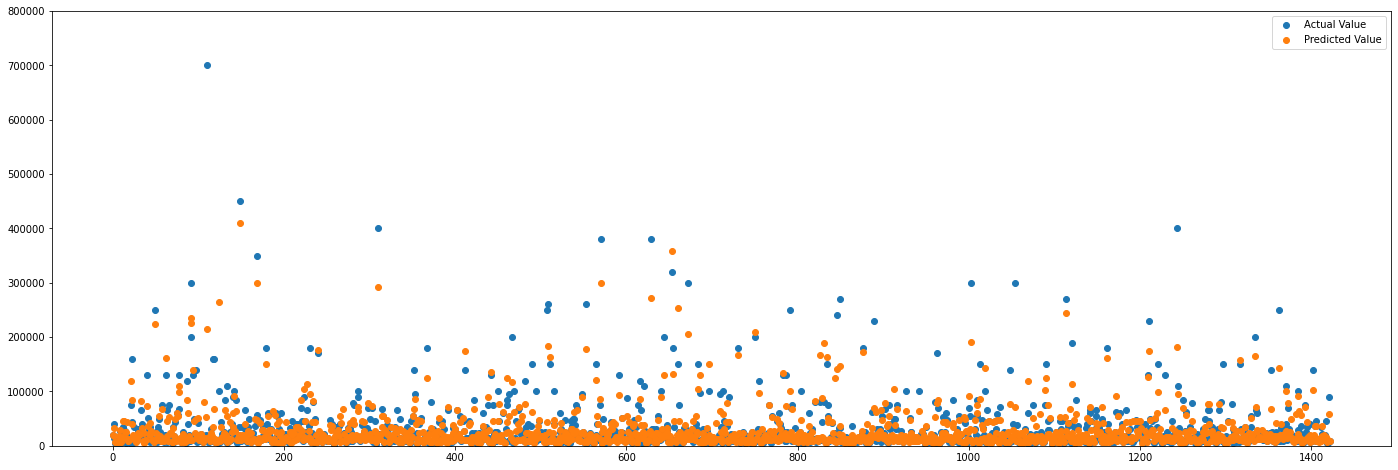

In [65]:
plt.figure(figsize=(24, 8))
plt.scatter(x=range(len(ytest)), y=ytest)
plt.scatter(x=range(len(ytest)), y=ypred)
plt.ylim([0,800000])
plt.legend(['Actual Value', 'Predicted Value'])
plt.show()